# The Comp-Act dataset

## Data

In [1]:
import numpy as np
from ignite.utils import manual_seed

In [2]:
data = np.loadtxt("../data/compact/compact/ComputerActivity/cpu_act.data",
              delimiter=',')

In [3]:
domain = np.loadtxt("../data/compact/compact/ComputerActivity/cpu_act.domain", 
                   dtype=str)

In [4]:
features = domain[:, 0]

Shuffle data

In [5]:
manual_seed(0)
shuffled_indices = np.random.permutation(len(data))

In [6]:
X_ca = data[shuffled_indices, 0:21].astype(np.float32)
y_ca = data[shuffled_indices, 21].reshape(-1, 1).astype(np.float32)

## Model

In [7]:
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from optuna.samplers import TPESampler
from optuna.integration.pytorch_ignite import PyTorchIgnitePruningHandler
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
from ignite.engine import Engine, Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Loss, RootMeanSquaredError
from ignite.handlers import EarlyStopping, LRScheduler, BasicTimeProfiler
from pyselect.networks import RandomFourierFeaturesNet
from pyselect.data import train_val_test_split
from pyselect.train import ridge_loss, score_function, best_model_callback

Set train, validation and test sizes

In [8]:
train_size = 6000
test_size = 1000
val_size = 1192

Data-splitting

In [9]:
X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(X_ca, y_ca, train_size, val_size, test_size)

Change scales

For X

In [10]:
from sklearn.preprocessing import StandardScaler

In [11]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

For y

In [12]:
y_train_mean = y_train.mean()

Apply scale changes

In [13]:
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
y_train -= y_train_mean
y_val -= y_train_mean
y_test -= y_train_mean

Convert to tensors

In [14]:
X_train, y_train = torch.from_numpy(X_train), torch.from_numpy(y_train)
X_val, y_val = torch.from_numpy(X_val), torch.from_numpy(y_val)
X_test, y_test = torch.from_numpy(X_test), torch.from_numpy(y_test)

In [15]:
train = torch.utils.data.TensorDataset(X_train, y_train)
val = torch.utils.data.TensorDataset(X_val, y_val)
test = torch.utils.data.TensorDataset(X_test, y_test)

Prepare dataloaders

In [16]:
train_loader = DataLoader(train, batch_size=32)
val_loader = DataLoader(val, batch_size=32)
test_loader = DataLoader(test, batch_size=32)

Objective for optuna

In [17]:
def objective(trial):
    
    # Set optimization seed
    seed = trial.number
    manual_seed(seed)
    trial.set_user_attr('random_seed', value=seed)    
    
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    trial.set_user_attr('device', value=device)
    
    in_features = 21
    out_features = 600
    model = RandomFourierFeaturesNet(in_features, out_features, torch.randn) 
    model.to(device) 

    lr = trial.suggest_float("learning_rate", 1e-4, 1e-3)
    optimizer = optim.SGD(model.parameters(), lr=lr)
    
    reg_param = trial.suggest_float("reg_param", 1e-7, 1e-5, log=True)
    loss_fn = lambda y_pred, y_true: ridge_loss(y_pred, y_true, model, reg_param)
    
    trainer = create_supervised_trainer(model, optimizer, loss_fn, device)
    
    # Add learning rate scheduler
    step_size = len(train_loader)*n_epochs//1.7
    torch_scheduler = StepLR(optimizer, step_size=step_size, gamma=0.5)
    scheduler = LRScheduler(torch_scheduler)
    trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)
        
    # Add evaluators
    val_metric = {"loss": Loss(loss_fn)}    
    train_evaluator = create_supervised_evaluator(model, metrics=val_metric, device=device)                                                
    val_evaluator = create_supervised_evaluator(model, metrics=val_metric, device=device)
    
    # Add pruner
    pruner = PyTorchIgnitePruningHandler(trial, 'loss', trainer)
    val_evaluator.add_event_handler(Events.COMPLETED, pruner)

    # Loggers
    log_every = 100
    @trainer.on(Events.EPOCH_COMPLETED(every=log_every))
    def log_training_results(engine):
        train_evaluator.run(train_loader)
        loss = train_evaluator.state.metrics['loss']
        print(f"Training - Epoch: {engine.state.epoch} Loss: {loss:.5f}")
        
    @trainer.on(Events.EPOCH_COMPLETED(every=log_every))
    def log_validation_results(engine):
        val_evaluator.run(val_loader)
        loss = val_evaluator.state.metrics['loss']
        print(f"Validation - Epoch: {engine.state.epoch} Loss: {loss:.5f}")    
        
    @trainer.on(Events.EPOCH_COMPLETED(every=log_every))
    def log_lr():
        print(f"Learning rate: {optimizer.param_groups[0]['lr']:.4f}")
        
    # Attach basic time profiler
    time_profiler = BasicTimeProfiler()
    time_profiler.attach(trainer)
    
    # Add early stopping 
    handler = EarlyStopping(patience=5, score_function=score_function, trainer=trainer)
    val_evaluator.add_event_handler(Events.COMPLETED, handler) 
    
    # Train the model
    trainer.run(train_loader, max_epochs=n_epochs)
    
    # Save best model in study parameters
    trial.set_user_attr(key='best_model', value=model)    
    
    # Time evaluation
    profiling_results = time_profiler.get_results()
    trial.set_user_attr(key='time_profiling', value=profiling_results)
    
    # Final evaluation
    val_evaluator.run(val_loader)
    val_loss = val_evaluator.state.metrics['loss']
    
    return val_loss

Initialize optuna study

In [18]:
tpe_sampler = TPESampler(seed=0)

In [19]:
study = optuna.create_study(direction='minimize', sampler=tpe_sampler)

[I 2022-02-23 14:48:36,988] A new study created in memory with name: no-name-b2f57625-26b2-4d0c-b211-b176e3c02401


Run study

In [20]:
n_epochs = 2701

In [21]:
study.optimize(objective, n_trials=30, callbacks=[best_model_callback])

Training - Epoch: 100 Loss: 68.06269
Validation - Epoch: 100 Loss: 74.09842
Learning rate: 0.0006
Training - Epoch: 200 Loss: 27.98970
Validation - Epoch: 200 Loss: 30.80024
Learning rate: 0.0006
Training - Epoch: 300 Loss: 18.97153
Validation - Epoch: 300 Loss: 22.01218
Learning rate: 0.0006
Training - Epoch: 400 Loss: 15.44098
Validation - Epoch: 400 Loss: 16.79368
Learning rate: 0.0006
Training - Epoch: 500 Loss: 13.71643
Validation - Epoch: 500 Loss: 14.67400
Learning rate: 0.0006
Training - Epoch: 600 Loss: 12.70331
Validation - Epoch: 600 Loss: 13.54263
Learning rate: 0.0006
Training - Epoch: 700 Loss: 11.97044
Validation - Epoch: 700 Loss: 12.78139
Learning rate: 0.0006
Training - Epoch: 800 Loss: 11.51390
Validation - Epoch: 800 Loss: 12.56903
Learning rate: 0.0006
Training - Epoch: 900 Loss: 11.43005
Validation - Epoch: 900 Loss: 13.45704
Learning rate: 0.0006
Training - Epoch: 1000 Loss: 10.77618
Validation - Epoch: 1000 Loss: 11.58179
Learning rate: 0.0006
Training - Epoch: 

2022-02-23 14:53:38,005 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training
/home/mpotto/.cache/pypoetry/virtualenvs/pyselect-ESLNoovx-py3.8/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 1500 is already reported.
  warnings.warn(
2022-02-23 14:53:38,039 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training
[I 2022-02-23 14:53:38,042] Trial 0 finished with value: 12.450370634962248 and parameters: {'learning_rate': 0.0005939321535345923, 'reg_param': 2.6938830192854074e-06}. Best is trial 0 with value: 12.450370634962248.


Training - Epoch: 1500 Loss: 10.61613
Validation - Epoch: 1500 Loss: 12.45037
Learning rate: 0.0006
Training - Epoch: 100 Loss: 70.27423
Validation - Epoch: 100 Loss: 80.81505
Learning rate: 0.0006
Training - Epoch: 200 Loss: 31.77233
Validation - Epoch: 200 Loss: 37.20630
Learning rate: 0.0006
Training - Epoch: 300 Loss: 22.06094
Validation - Epoch: 300 Loss: 24.53993
Learning rate: 0.0006
Training - Epoch: 400 Loss: 18.36422
Validation - Epoch: 400 Loss: 19.57923
Learning rate: 0.0006
Training - Epoch: 500 Loss: 16.65698
Validation - Epoch: 500 Loss: 18.13889
Learning rate: 0.0006
Training - Epoch: 600 Loss: 15.52271
Validation - Epoch: 600 Loss: 16.48491
Learning rate: 0.0006
Training - Epoch: 700 Loss: 14.74735
Validation - Epoch: 700 Loss: 17.10630
Learning rate: 0.0006
Training - Epoch: 800 Loss: 13.51846
Validation - Epoch: 800 Loss: 14.04321
Learning rate: 0.0006
Training - Epoch: 900 Loss: 12.79695
Validation - Epoch: 900 Loss: 13.26214
Learning rate: 0.0006
Training - Epoch: 

[I 2022-02-23 15:02:35,647] Trial 1 finished with value: 10.09091780489723 and parameters: {'learning_rate': 0.0006424870384644795, 'reg_param': 1.2296071107325702e-06}. Best is trial 1 with value: 10.09091780489723.


Training - Epoch: 100 Loss: 97.38358
Validation - Epoch: 100 Loss: 105.99021
Learning rate: 0.0005
Training - Epoch: 200 Loss: 44.28432
Validation - Epoch: 200 Loss: 47.03916
Learning rate: 0.0005
Training - Epoch: 300 Loss: 27.20693
Validation - Epoch: 300 Loss: 29.06065
Learning rate: 0.0005
Training - Epoch: 400 Loss: 20.61362
Validation - Epoch: 400 Loss: 22.36166
Learning rate: 0.0005
Training - Epoch: 500 Loss: 17.53293
Validation - Epoch: 500 Loss: 19.40813
Learning rate: 0.0005
Training - Epoch: 600 Loss: 15.70042
Validation - Epoch: 600 Loss: 17.42820
Learning rate: 0.0005
Training - Epoch: 700 Loss: 14.40654
Validation - Epoch: 700 Loss: 16.06949
Learning rate: 0.0005
Training - Epoch: 800 Loss: 13.64654
Validation - Epoch: 800 Loss: 15.96501
Learning rate: 0.0005
Training - Epoch: 900 Loss: 13.16674
Validation - Epoch: 900 Loss: 16.52235
Learning rate: 0.0005
Training - Epoch: 1000 Loss: 12.33590
Validation - Epoch: 1000 Loss: 14.58610
Learning rate: 0.0005
Training - Epoch:

[I 2022-02-23 15:11:34,794] Trial 2 finished with value: 9.4520263671875 and parameters: {'learning_rate': 0.00048128931940501424, 'reg_param': 1.9578897201213005e-06}. Best is trial 2 with value: 9.4520263671875.


Training - Epoch: 100 Loss: 120.80882
Validation - Epoch: 100 Loss: 135.64502
Learning rate: 0.0005
Training - Epoch: 200 Loss: 61.14479
Validation - Epoch: 200 Loss: 70.83080
Learning rate: 0.0005
Training - Epoch: 300 Loss: 37.95190
Validation - Epoch: 300 Loss: 44.72475
Learning rate: 0.0005
Training - Epoch: 400 Loss: 29.02819
Validation - Epoch: 400 Loss: 34.18402
Learning rate: 0.0005
Training - Epoch: 500 Loss: 25.21510
Validation - Epoch: 500 Loss: 30.01043
Learning rate: 0.0005
Training - Epoch: 600 Loss: 22.92479
Validation - Epoch: 600 Loss: 26.99216
Learning rate: 0.0005
Training - Epoch: 700 Loss: 22.57653
Validation - Epoch: 700 Loss: 27.84288
Learning rate: 0.0005
Training - Epoch: 800 Loss: 19.62396
Validation - Epoch: 800 Loss: 23.58224
Learning rate: 0.0005
Training - Epoch: 900 Loss: 19.53071
Validation - Epoch: 900 Loss: 24.08944
Learning rate: 0.0005
Training - Epoch: 1000 Loss: 18.72206
Validation - Epoch: 1000 Loss: 22.28888
Learning rate: 0.0005
Training - Epoch

[I 2022-02-23 15:21:41,814] Trial 3 finished with value: 17.329488255033556 and parameters: {'learning_rate': 0.0004938284901364233, 'reg_param': 6.0749960734256916e-06}. Best is trial 2 with value: 9.4520263671875.


Training - Epoch: 100 Loss: 55.92280
Validation - Epoch: 100 Loss: 62.32881
Learning rate: 0.0010
Training - Epoch: 200 Loss: 24.35702
Validation - Epoch: 200 Loss: 26.36932
Learning rate: 0.0010
Training - Epoch: 300 Loss: 16.07710
Validation - Epoch: 300 Loss: 17.32844
Learning rate: 0.0010
Training - Epoch: 400 Loss: 13.35591
Validation - Epoch: 400 Loss: 14.77034
Learning rate: 0.0010
Training - Epoch: 500 Loss: 11.84191
Validation - Epoch: 500 Loss: 13.31574
Learning rate: 0.0010
Training - Epoch: 600 Loss: 11.04359
Validation - Epoch: 600 Loss: 12.43952
Learning rate: 0.0010
Training - Epoch: 700 Loss: 10.55229
Validation - Epoch: 700 Loss: 11.93004
Learning rate: 0.0010
Training - Epoch: 800 Loss: 10.33653
Validation - Epoch: 800 Loss: 11.67678
Learning rate: 0.0010
Training - Epoch: 900 Loss: 9.92623
Validation - Epoch: 900 Loss: 11.16912
Learning rate: 0.0010
Training - Epoch: 1000 Loss: 9.76842
Validation - Epoch: 1000 Loss: 11.11604
Learning rate: 0.0010
Training - Epoch: 11

[I 2022-02-23 15:31:36,639] Trial 4 finished with value: 9.599572508127098 and parameters: {'learning_rate': 0.0009672964844509264, 'reg_param': 5.846326121643413e-07}. Best is trial 2 with value: 9.4520263671875.


Training - Epoch: 100 Loss: 58.58361
Validation - Epoch: 100 Loss: 65.44868
Learning rate: 0.0008
Training - Epoch: 200 Loss: 24.57439
Validation - Epoch: 200 Loss: 29.25076
Learning rate: 0.0008
Training - Epoch: 300 Loss: 16.72673
Validation - Epoch: 300 Loss: 19.54906
Learning rate: 0.0008
Training - Epoch: 400 Loss: 14.67145
Validation - Epoch: 400 Loss: 18.56792
Learning rate: 0.0008
Training - Epoch: 500 Loss: 13.12327
Validation - Epoch: 500 Loss: 15.87778
Learning rate: 0.0008
Training - Epoch: 600 Loss: 12.41183
Validation - Epoch: 600 Loss: 14.84968
Learning rate: 0.0008
Training - Epoch: 700 Loss: 11.87172
Validation - Epoch: 700 Loss: 15.05519
Learning rate: 0.0008


Engine run is terminating due to exception: Trial was pruned at 800 epoch.
Engine run is terminating due to exception: Trial was pruned at 800 epoch.
[I 2022-02-23 15:34:34,697] Trial 5 pruned. Trial was pruned at 800 epoch.


Training - Epoch: 800 Loss: 11.32074


Engine run is terminating due to exception: Trial was pruned at 100 epoch.
Engine run is terminating due to exception: Trial was pruned at 100 epoch.
[I 2022-02-23 15:34:56,175] Trial 6 pruned. Trial was pruned at 100 epoch.


Training - Epoch: 100 Loss: 95.29287


Engine run is terminating due to exception: Trial was pruned at 100 epoch.
Engine run is terminating due to exception: Trial was pruned at 100 epoch.
[I 2022-02-23 15:35:17,100] Trial 7 pruned. Trial was pruned at 100 epoch.


Training - Epoch: 100 Loss: 212.78317


Engine run is terminating due to exception: Trial was pruned at 100 epoch.
Engine run is terminating due to exception: Trial was pruned at 100 epoch.
[I 2022-02-23 15:35:38,447] Trial 8 pruned. Trial was pruned at 100 epoch.


Training - Epoch: 100 Loss: 224.36421
Training - Epoch: 100 Loss: 57.87640
Validation - Epoch: 100 Loss: 66.58225
Learning rate: 0.0008
Training - Epoch: 200 Loss: 24.73326
Validation - Epoch: 200 Loss: 26.63037
Learning rate: 0.0008
Training - Epoch: 300 Loss: 18.25756
Validation - Epoch: 300 Loss: 20.44613
Learning rate: 0.0008
Training - Epoch: 400 Loss: 15.23521
Validation - Epoch: 400 Loss: 16.21095
Learning rate: 0.0008
Training - Epoch: 500 Loss: 14.20793
Validation - Epoch: 500 Loss: 14.37721
Learning rate: 0.0008
Training - Epoch: 600 Loss: 13.61809
Validation - Epoch: 600 Loss: 13.96134
Learning rate: 0.0008
Training - Epoch: 700 Loss: 12.69569
Validation - Epoch: 700 Loss: 13.03966
Learning rate: 0.0008
Training - Epoch: 800 Loss: 12.98960
Validation - Epoch: 800 Loss: 14.33256
Learning rate: 0.0008
Training - Epoch: 900 Loss: 12.11078
Validation - Epoch: 900 Loss: 12.28725
Learning rate: 0.0008
Training - Epoch: 1000 Loss: 12.72974
Validation - Epoch: 1000 Loss: 14.66070
Le

Engine run is terminating due to exception: Trial was pruned at 1100 epoch.
Engine run is terminating due to exception: Trial was pruned at 1100 epoch.
[I 2022-02-23 15:39:41,458] Trial 9 pruned. Trial was pruned at 1100 epoch.


Training - Epoch: 1100 Loss: 12.68335


Engine run is terminating due to exception: Trial was pruned at 100 epoch.
Engine run is terminating due to exception: Trial was pruned at 100 epoch.
[I 2022-02-23 15:40:03,106] Trial 10 pruned. Trial was pruned at 100 epoch.


Training - Epoch: 100 Loss: 157.73830
Training - Epoch: 100 Loss: 44.13828
Validation - Epoch: 100 Loss: 47.00512
Learning rate: 0.0010
Training - Epoch: 200 Loss: 20.73546
Validation - Epoch: 200 Loss: 22.07223
Learning rate: 0.0010
Training - Epoch: 300 Loss: 14.86509
Validation - Epoch: 300 Loss: 17.07471
Learning rate: 0.0010
Training - Epoch: 400 Loss: 12.83671
Validation - Epoch: 400 Loss: 13.73500
Learning rate: 0.0010
Training - Epoch: 500 Loss: 12.14197
Validation - Epoch: 500 Loss: 13.41996
Learning rate: 0.0010
Training - Epoch: 600 Loss: 12.36592
Validation - Epoch: 600 Loss: 15.48739
Learning rate: 0.0010
Training - Epoch: 700 Loss: 11.46619
Validation - Epoch: 700 Loss: 12.84212
Learning rate: 0.0010
Training - Epoch: 800 Loss: 11.54419
Validation - Epoch: 800 Loss: 14.33410
Learning rate: 0.0010
Training - Epoch: 900 Loss: 10.90669
Validation - Epoch: 900 Loss: 11.86048
Learning rate: 0.0010
Training - Epoch: 1000 Loss: 10.83484
Validation - Epoch: 1000 Loss: 11.83415
Le

Engine run is terminating due to exception: Trial was pruned at 1400 epoch.
Engine run is terminating due to exception: Trial was pruned at 1400 epoch.
[I 2022-02-23 15:45:14,028] Trial 11 pruned. Trial was pruned at 1400 epoch.


Training - Epoch: 1400 Loss: 10.72802


Engine run is terminating due to exception: Trial was pruned at 100 epoch.
Engine run is terminating due to exception: Trial was pruned at 100 epoch.
[I 2022-02-23 15:45:36,413] Trial 12 pruned. Trial was pruned at 100 epoch.


Training - Epoch: 100 Loss: 129.86015
Training - Epoch: 100 Loss: 65.43329
Validation - Epoch: 100 Loss: 78.45750
Learning rate: 0.0008
Training - Epoch: 200 Loss: 29.50103
Validation - Epoch: 200 Loss: 36.92634
Learning rate: 0.0008


Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-23 15:46:40,127] Trial 13 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 20.73437
Training - Epoch: 100 Loss: 46.85522
Validation - Epoch: 100 Loss: 53.93203
Learning rate: 0.0010
Training - Epoch: 200 Loss: 18.86287
Validation - Epoch: 200 Loss: 22.82724
Learning rate: 0.0010
Training - Epoch: 300 Loss: 13.10132
Validation - Epoch: 300 Loss: 13.93379
Learning rate: 0.0010
Training - Epoch: 400 Loss: 11.38486
Validation - Epoch: 400 Loss: 11.82018
Learning rate: 0.0010
Training - Epoch: 500 Loss: 11.08956
Validation - Epoch: 500 Loss: 13.54308
Learning rate: 0.0010
Training - Epoch: 600 Loss: 10.33710
Validation - Epoch: 600 Loss: 10.94210
Learning rate: 0.0010
Training - Epoch: 700 Loss: 10.47415
Validation - Epoch: 700 Loss: 13.06982
Learning rate: 0.0010
Training - Epoch: 800 Loss: 10.25349
Validation - Epoch: 800 Loss: 12.71223
Learning rate: 0.0010
Training - Epoch: 900 Loss: 9.89392
Validation - Epoch: 900 Loss: 12.05366
Learning rate: 0.0010
Training - Epoch: 1000 Loss: 10.08238
Validation - Epoch: 1000 Loss: 12.60816
Lear

[I 2022-02-23 15:56:32,537] Trial 14 finished with value: 8.84345588428062 and parameters: {'learning_rate': 0.0009948116958280154, 'reg_param': 1.484043353996687e-07}. Best is trial 14 with value: 8.84345588428062.
Engine run is terminating due to exception: Trial was pruned at 100 epoch.
Engine run is terminating due to exception: Trial was pruned at 100 epoch.
[I 2022-02-23 15:56:53,502] Trial 15 pruned. Trial was pruned at 100 epoch.


Training - Epoch: 100 Loss: 148.48690


Engine run is terminating due to exception: Trial was pruned at 100 epoch.
Engine run is terminating due to exception: Trial was pruned at 100 epoch.
[I 2022-02-23 15:57:14,389] Trial 16 pruned. Trial was pruned at 100 epoch.


Training - Epoch: 100 Loss: 98.62880
Training - Epoch: 100 Loss: 62.47756
Validation - Epoch: 100 Loss: 67.87203
Learning rate: 0.0007
Training - Epoch: 200 Loss: 25.93712
Validation - Epoch: 200 Loss: 28.06470
Learning rate: 0.0007
Training - Epoch: 300 Loss: 17.36540
Validation - Epoch: 300 Loss: 19.76620
Learning rate: 0.0007
Training - Epoch: 400 Loss: 14.09731
Validation - Epoch: 400 Loss: 15.00977
Learning rate: 0.0007
Training - Epoch: 500 Loss: 12.60578
Validation - Epoch: 500 Loss: 13.36336
Learning rate: 0.0007
Training - Epoch: 600 Loss: 11.80476
Validation - Epoch: 600 Loss: 12.40364
Learning rate: 0.0007
Training - Epoch: 700 Loss: 11.19967
Validation - Epoch: 700 Loss: 11.72668
Learning rate: 0.0007
Training - Epoch: 800 Loss: 10.97576
Validation - Epoch: 800 Loss: 11.90447
Learning rate: 0.0007
Training - Epoch: 900 Loss: 10.61721
Validation - Epoch: 900 Loss: 11.53687
Learning rate: 0.0007
Training - Epoch: 1000 Loss: 10.65401
Validation - Epoch: 1000 Loss: 11.55143
Lea

[I 2022-02-23 16:07:08,363] Trial 17 finished with value: 9.001276413066275 and parameters: {'learning_rate': 0.0007316011382825938, 'reg_param': 2.0764624043112265e-06}. Best is trial 14 with value: 8.84345588428062.


Training - Epoch: 100 Loss: 49.90065
Validation - Epoch: 100 Loss: 54.38967
Learning rate: 0.0009
Training - Epoch: 200 Loss: 19.58533
Validation - Epoch: 200 Loss: 21.16669
Learning rate: 0.0009
Training - Epoch: 300 Loss: 14.67012
Validation - Epoch: 300 Loss: 16.01367
Learning rate: 0.0009
Training - Epoch: 400 Loss: 12.81774
Validation - Epoch: 400 Loss: 16.30901
Learning rate: 0.0009
Training - Epoch: 500 Loss: 11.64523
Validation - Epoch: 500 Loss: 13.31364
Learning rate: 0.0009
Training - Epoch: 600 Loss: 11.24889
Validation - Epoch: 600 Loss: 14.22377
Learning rate: 0.0009
Training - Epoch: 700 Loss: 10.61638
Validation - Epoch: 700 Loss: 11.28780
Learning rate: 0.0009
Training - Epoch: 800 Loss: 10.77211
Validation - Epoch: 800 Loss: 11.84590
Learning rate: 0.0009
Training - Epoch: 900 Loss: 11.16562
Validation - Epoch: 900 Loss: 16.76831
Learning rate: 0.0009
Training - Epoch: 1000 Loss: 10.76198
Validation - Epoch: 1000 Loss: 15.65612
Learning rate: 0.0009
Training - Epoch: 

2022-02-23 16:15:51,897 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training
/home/mpotto/.cache/pypoetry/virtualenvs/pyselect-ESLNoovx-py3.8/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 2400 is already reported.
  warnings.warn(
2022-02-23 16:15:51,934 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training
[I 2022-02-23 16:15:51,936] Trial 18 finished with value: 9.145503716180789 and parameters: {'learning_rate': 0.000868644586089045, 'reg_param': 1.9733043274256124e-07}. Best is trial 14 with value: 8.84345588428062.


Training - Epoch: 2400 Loss: 8.50281
Validation - Epoch: 2400 Loss: 9.14550
Learning rate: 0.0004
Training - Epoch: 100 Loss: 53.72319
Validation - Epoch: 100 Loss: 58.54495
Learning rate: 0.0007
Training - Epoch: 200 Loss: 20.86315
Validation - Epoch: 200 Loss: 21.92651
Learning rate: 0.0007
Training - Epoch: 300 Loss: 14.72357
Validation - Epoch: 300 Loss: 15.94150
Learning rate: 0.0007
Training - Epoch: 400 Loss: 12.75892
Validation - Epoch: 400 Loss: 13.75788
Learning rate: 0.0007
Training - Epoch: 500 Loss: 11.97373
Validation - Epoch: 500 Loss: 12.81752
Learning rate: 0.0007
Training - Epoch: 600 Loss: 11.71337
Validation - Epoch: 600 Loss: 12.59808
Learning rate: 0.0007
Training - Epoch: 700 Loss: 11.22118
Validation - Epoch: 700 Loss: 11.95482
Learning rate: 0.0007
Training - Epoch: 800 Loss: 10.45281
Validation - Epoch: 800 Loss: 11.19163
Learning rate: 0.0007
Training - Epoch: 900 Loss: 10.52273
Validation - Epoch: 900 Loss: 11.25831
Learning rate: 0.0007
Training - Epoch: 10

Engine run is terminating due to exception: Trial was pruned at 1600 epoch.
Engine run is terminating due to exception: Trial was pruned at 1600 epoch.
[I 2022-02-23 16:21:40,875] Trial 19 pruned. Trial was pruned at 1600 epoch.


Training - Epoch: 1600 Loss: 9.66903


Engine run is terminating due to exception: Trial was pruned at 100 epoch.
Engine run is terminating due to exception: Trial was pruned at 100 epoch.
[I 2022-02-23 16:22:03,035] Trial 20 pruned. Trial was pruned at 100 epoch.


Training - Epoch: 100 Loss: 61.76293
Training - Epoch: 100 Loss: 57.74562
Validation - Epoch: 100 Loss: 61.93685
Learning rate: 0.0009
Training - Epoch: 200 Loss: 22.59647
Validation - Epoch: 200 Loss: 23.55861
Learning rate: 0.0009
Training - Epoch: 300 Loss: 14.91192
Validation - Epoch: 300 Loss: 15.96601
Learning rate: 0.0009
Training - Epoch: 400 Loss: 13.06300
Validation - Epoch: 400 Loss: 14.21579
Learning rate: 0.0009


Engine run is terminating due to exception: Trial was pruned at 500 epoch.
Engine run is terminating due to exception: Trial was pruned at 500 epoch.
[I 2022-02-23 16:23:52,478] Trial 21 pruned. Trial was pruned at 500 epoch.


Training - Epoch: 500 Loss: 12.40991


Engine run is terminating due to exception: Trial was pruned at 100 epoch.
Engine run is terminating due to exception: Trial was pruned at 100 epoch.
[I 2022-02-23 16:24:16,014] Trial 22 pruned. Trial was pruned at 100 epoch.


Training - Epoch: 100 Loss: 73.60433
Training - Epoch: 100 Loss: 51.04845
Validation - Epoch: 100 Loss: 63.18789
Learning rate: 0.0010


Engine run is terminating due to exception: Trial was pruned at 200 epoch.
Engine run is terminating due to exception: Trial was pruned at 200 epoch.
[I 2022-02-23 16:25:00,133] Trial 23 pruned. Trial was pruned at 200 epoch.


Training - Epoch: 200 Loss: 24.48901
Training - Epoch: 100 Loss: 49.77868
Validation - Epoch: 100 Loss: 54.00511
Learning rate: 0.0009
Training - Epoch: 200 Loss: 22.03570
Validation - Epoch: 200 Loss: 23.74938
Learning rate: 0.0009
Training - Epoch: 300 Loss: 17.85148
Validation - Epoch: 300 Loss: 19.89570
Learning rate: 0.0009


Engine run is terminating due to exception: Trial was pruned at 400 epoch.
Engine run is terminating due to exception: Trial was pruned at 400 epoch.
[I 2022-02-23 16:26:26,352] Trial 24 pruned. Trial was pruned at 400 epoch.


Training - Epoch: 400 Loss: 15.46322


Engine run is terminating due to exception: Trial was pruned at 100 epoch.
Engine run is terminating due to exception: Trial was pruned at 100 epoch.
[I 2022-02-23 16:26:49,138] Trial 25 pruned. Trial was pruned at 100 epoch.


Training - Epoch: 100 Loss: 67.33856


Engine run is terminating due to exception: Trial was pruned at 100 epoch.
Engine run is terminating due to exception: Trial was pruned at 100 epoch.
[I 2022-02-23 16:27:11,629] Trial 26 pruned. Trial was pruned at 100 epoch.


Training - Epoch: 100 Loss: 60.87590
Training - Epoch: 100 Loss: 61.14218
Validation - Epoch: 100 Loss: 66.40956
Learning rate: 0.0008
Training - Epoch: 200 Loss: 26.96844
Validation - Epoch: 200 Loss: 28.88577
Learning rate: 0.0008
Training - Epoch: 300 Loss: 17.49859
Validation - Epoch: 300 Loss: 19.44975
Learning rate: 0.0008
Training - Epoch: 400 Loss: 13.63942
Validation - Epoch: 400 Loss: 15.10591
Learning rate: 0.0008


Engine run is terminating due to exception: Trial was pruned at 500 epoch.
Engine run is terminating due to exception: Trial was pruned at 500 epoch.
[I 2022-02-23 16:29:00,354] Trial 27 pruned. Trial was pruned at 500 epoch.


Training - Epoch: 500 Loss: 12.43481


Engine run is terminating due to exception: Trial was pruned at 100 epoch.
Engine run is terminating due to exception: Trial was pruned at 100 epoch.
[I 2022-02-23 16:29:23,082] Trial 28 pruned. Trial was pruned at 100 epoch.


Training - Epoch: 100 Loss: 68.31836


Engine run is terminating due to exception: Trial was pruned at 100 epoch.
Engine run is terminating due to exception: Trial was pruned at 100 epoch.
[I 2022-02-23 16:29:44,360] Trial 29 pruned. Trial was pruned at 100 epoch.


Training - Epoch: 100 Loss: 95.04212


Get best model

In [22]:
best_model = study.user_attrs['best_model']

In [23]:
torch.save(best_model.state_dict(), '../models/comp-act.pth')

Replicate best model on different test sets

In [24]:
def replicate(trial):
    # Set replication seed
    seed = trial.number + 1000
    manual_seed(seed)
    trial.set_user_attr('random_seed', value=seed)    
    
    test = torch.utils.data.TensorDataset(X_test, y_test)
    test_loader = DataLoader(test, batch_size=test_size)
    
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    trial.set_user_attr('device', value=device)
    
    reg_param = study.best_params['reg_param']
    loss_fn = lambda y_pred, y_true: ridge_loss(y_pred, y_true, best_model, reg_param)
    
    best_model.to(device) 
        
    # Add evaluators
    test_metric = {'rmse': RootMeanSquaredError()}    
    test_evaluator = create_supervised_evaluator(best_model, metrics=test_metric, device=device)
    
    # Final evaluation
    test_evaluator.run(test_loader)
    test_rmse = test_evaluator.state.metrics['rmse']
    
    return test_rmse

In [25]:
replication = optuna.create_study(direction='minimize')

[I 2022-02-23 16:29:44,395] A new study created in memory with name: no-name-df7c320b-62ab-4b95-9509-f16a4d6cc3a5


In [26]:
replication.optimize(replicate, n_trials=1)

[I 2022-02-23 16:29:44,406] Trial 0 finished with value: 2.8540356569689176 and parameters: {}. Best is trial 0 with value: 2.8540356569689176.


## Visualization

In [27]:
import matplotlib.pyplot as plt

### Bands

In [28]:
bands = best_model.rff_net[0].bandwidths.detach().to('cpu').numpy()
indexes = np.arange(1, len(features))

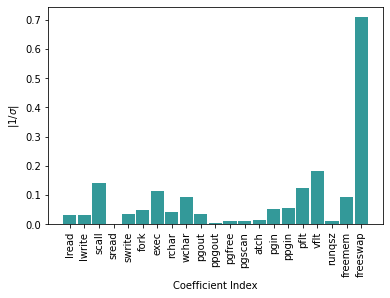

In [29]:
plt.bar(indexes, np.abs(bands), width=0.9, alpha=0.8, color='teal')
ax = plt.gca()
ax.ticklabel_format(axis="x", style="plain")
ax.set_xlabel("Coefficient Index")
ax.set_ylabel(r"$| 1/\sigma |$")
plt.xticks(indexes, features[:-1], rotation=90)
plt.show()

### Predictions on test

In [30]:
best_model.to('cpu')

RandomFourierFeaturesNet(
  (rff_net): Sequential(
    (0): HadamardLayer(in_features=21)
    (1): RandomFourierFeaturesLayer(in_features=21, out_features=600)
    (2): Linear(in_features=600, out_features=1, bias=True)
  )
)

In [31]:
sorted_y_test = y_test.squeeze().sort(dim=0)[0].numpy()

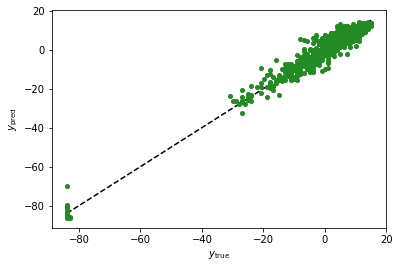

In [32]:
plt.plot(y_test, best_model(X_test).detach().squeeze().numpy(), 'o', markersize=4, color='forestgreen')
plt.plot(sorted_y_test, sorted_y_test, color='k', linestyle='dashed', zorder=-10)
plt.xlabel(r"$y_{\mathrm{true}}$")
plt.ylabel(r"$y_{\mathrm{pred}}$")
plt.show()